# Comparing a conventional and approximate Single-Output GP

In [1]:
import math

import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np

import famgpytorch

%matplotlib inline
%load_ext autoreload
%autoreload 2
torch.manual_seed(42)
None


## Set up some very simple training data

$$
\begin{equation}
y = x
\end{equation}
$$
With training examples test examples regularly spaced points in [0,1]

In [2]:
nb_training_points = 2
nb_test_points = 1

train_x = torch.linspace(0, 1, nb_training_points)
train_y = train_x.pow(2)

## Setting up the models
Both **GP Models** `gpytorch.models.ExactGP` with:
- **Likelihood** `gpytorch.likelihoods.GaussianLikelihood`
- **Zero Mean** `gpytorch.means.ZeroMean` for simplicity

One model witch conventional kernel:
- **RBF Kernel** `gpytorch.kernels.RBFKernel`

One model with approximate kernel:
- **Approximate RBF Kernel** `famgpytorch.kernels.RBFKernelApprox`

In [3]:
class ConventionalGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_inputs, train_targets, likelihood):
        super(ConventionalGPModel, self).__init__(train_inputs, train_targets, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.RBFKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class ApproxGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_inputs, train_targets, likelihood):
        super(ApproxGPModel, self).__init__(train_inputs, train_targets, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = famgpytorch.kernels.RBFKernelApprox()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


## Training the model

In [4]:
conv_likelihood = gpytorch.likelihoods.GaussianLikelihood()
# workaround for noise-free GP
# conv_likelihood.noise = 2e-4
# conv_likelihood.noise_covar.raw_noise.requires_grad_(False)
conv_model = ConventionalGPModel(train_x, train_y, conv_likelihood)
approx_likelihood = gpytorch.likelihoods.GaussianLikelihood()
# workaround for noise-free GP
# approx_likelihood.noise = 2e-4
# approx_likelihood.noise_covar.raw_noise.requires_grad_(False)
approx_model = ApproxGPModel(train_x, train_y, approx_likelihood)
approx_model.covar_module.alpha = 1
approx_model.covar_module.raw_alpha.requires_grad_(False)
#---------------------------------------------------------------------

# set model in training mode
conv_model.train()
approx_model.train()
conv_likelihood.train()
approx_likelihood.train()

# use adam optimizer, including the GaussianLikelihood parameters
conv_optimizer = torch.optim.Adam(conv_model.parameters(), lr=0.1)
approx_optimizer = torch.optim.Adam(approx_model.parameters(), lr=0.1)

# "Loss" for GPs - marginal log likelihood
conv_mll = gpytorch.mlls.ExactMarginalLogLikelihood(conv_likelihood, conv_model)
approx_mll = gpytorch.mlls.ExactMarginalLogLikelihood(approx_likelihood, approx_model)

for i in range(1):
    # zero gradients from previous iteration
    conv_optimizer.zero_grad()
    approx_optimizer.zero_grad()

    # output from model -> multivariate normal with mean vector and covariance matrix
    conv_output = conv_model(train_x)
    approx_output = approx_model(train_x)

    # calc loss (negative marginal log likelihood)
    conv_loss = -conv_mll(conv_output, train_y)
    approx_loss = -approx_mll(approx_output, train_y)

    # backprop gradients
    conv_loss.backward()
    approx_loss.backward()

    # if i == 0 or (i + 1) % 10 == 0:
    print(f'Iter {i + 1:02d}/50')
    print(
        f'\tConventional:   Loss: {conv_loss.item():.3f}   '
        f'lengthscale: {conv_model.covar_module.lengthscale.item():.3f}   '
        f'noise: {conv_model.likelihood.noise.item():.3f}'
    )
    print(
        f'\tApproximate:   Loss: {approx_loss.item():.3f}   '
        f'lengthscale: {approx_model.covar_module.lengthscale.item():.3f}   '
        f'noise: {approx_model.likelihood.noise.item():.3f}   '
        f'alpha: {approx_model.covar_module.alpha.item():.3f}'
    )

    # step on optimizer
    conv_optimizer.step()
    approx_optimizer.step()

eigenfunctions x1: tensor([[ 0.0000, -1.7363, -0.0000,  3.0074,  0.0000],
        [ 1.9257,  5.1666,  9.5732, 11.4587,  4.7232]], grad_fn=<CatBackward0>)
eigenvalues: tensor([[0.2376, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0924, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0359, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0140, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0054]])
eigenfunction x2^T: tensor([[ 0.0000,  1.9257],
        [-1.7363,  5.1666],
        [-0.0000,  9.5732],
        [ 3.0074, 11.4587],
        [ 0.0000,  4.7232]], grad_fn=<TransposeBackward0>)
Iter 01/50
	Conventional:   Loss: 1.326   lengthscale: 0.693   noise: 0.693
	Approximate:   Loss: 1.524   lengthscale: 0.693   noise: 0.693   alpha: 1.000


### Resulting covariance matrix

--Conventional--
	covar:	 tensor([[1.0000, 0.4056],
					 [0.4056, 1.0000]])

--Approximate--
eigenfunctions x1: tensor([[ 0.0000, -1.7119, -0.0000,  2.9650,  0.0000],
        [ 1.8455,  4.7784,  8.4198,  9.1706,  1.9351]])
eigenvalues: tensor([[0.2316, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0844, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0308, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0112, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0041]])
eigenfunction x2^T: tensor([[ 0.0000,  1.8455],
        [-1.7119,  4.7784],
        [-0.0000,  8.4198],
        [ 2.9650,  9.1706],
        [ 0.0000,  1.9351]])
	covar:	 tensor([[ 0.3460, -0.3856],
					 [-0.3856,  5.8560]])


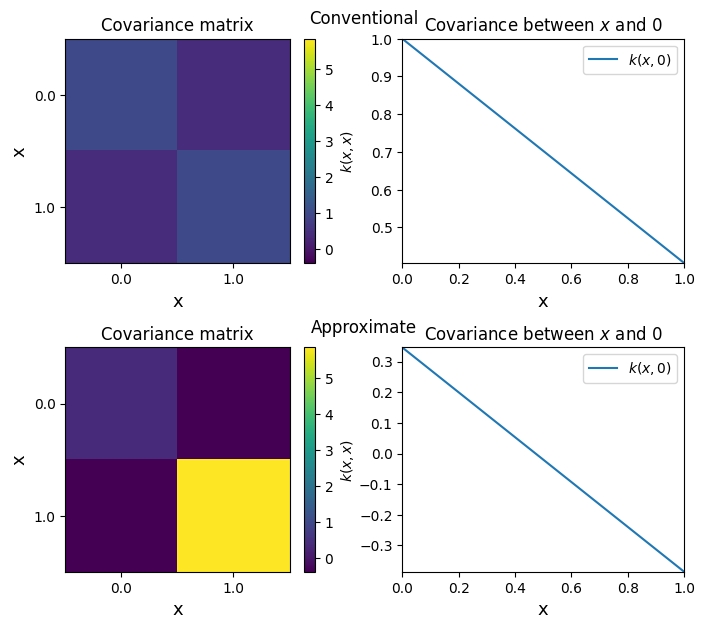

In [5]:
with torch.no_grad():
    print("--Conventional--")
    conv_f_train = conv_model(train_x)
    conv_train_covar = conv_f_train.covariance_matrix
    print("\tcovar:\t", conv_train_covar.__repr__().replace(
        '\n        ',
        '\n' + 5*'\t' + ' '
    ))

    print("\n--Approximate--")
    approx_f_train = approx_model(train_x)
    approx_train_covar = approx_f_train.covariance_matrix
    print("\tcovar:\t", approx_train_covar.__repr__().replace(
        '\n        ',
        '\n' + 5*'\t' + ' '
    ))

    # plot for x in [-1, 1]
    # plot resulting covariance matrix
    fig = plt.figure(figsize=(8, 6))
    subfigs = fig.subfigures(2, 1, hspace=0.06)
    subfigs[0].suptitle("Conventional")
    subfigs[1].suptitle("Approximate")
    vmin = torch.min(torch.cat((conv_train_covar, approx_train_covar))).item()
    vmax = torch.max(torch.cat((conv_train_covar, approx_train_covar))).item()
    for row, covar in enumerate([conv_train_covar, approx_train_covar]):
        ax1, ax2 = subfigs[row].subplots(1, 2)

        im = ax1.imshow(covar.numpy(), cmap=plt.colormaps['viridis'], vmin=vmin, vmax=vmax)
        cbar = plt.colorbar(im, ax=ax1)
        cbar.ax.set_ylabel('$k(x,x)$', fontsize=10)
        ax1.set_title("Covariance matrix")
        ax1.set_xlabel('x', fontsize=13)
        ax1.set_ylabel('x', fontsize=13)
        ax1.set_xticks(np.linspace(0, nb_training_points - 1, min(nb_training_points, 6)))
        ax1.set_yticks(np.linspace(0, nb_training_points - 1, min(nb_training_points, 6)))
        ax1.set_xticklabels(np.round(np.linspace(0, 1, min(nb_training_points, 6)), 2))
        ax1.set_yticklabels(np.round(np.linspace(0, 1, min(nb_training_points, 6)), 2))
        ax1.grid(False)

        ax2.plot(train_x.numpy(), covar.numpy()[:,0], label='$k(x,0)$')
        ax2.set_xlabel('x', fontsize=13)
        ax2.set_title('Covariance between $x$ and $0$')
        ax2.set_xlim([0, 1])
        ax2.set_ylim([np.min(covar.numpy()[:,0]), np.max(covar.numpy()[:,0])])
        ax2.legend(loc=1)

## Make predictions with the models

eigenfunctions x1: tensor([[ 0.0000, -1.7119, -0.0000,  2.9650,  0.0000]])
eigenvalues: tensor([[0.2316, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0844, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0308, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0112, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0041]])
eigenfunction x2^T: tensor([[ 0.0000,  1.8455,  0.0000],
        [-1.7119,  4.7784, -1.7119],
        [-0.0000,  8.4198, -0.0000],
        [ 2.9650,  9.1706,  2.9650],
        [ 0.0000,  1.9351,  0.0000]])
eigenfunctions x1: tensor([[ 0.0000, -1.7119, -0.0000,  2.9650,  0.0000],
        [ 1.8455,  4.7784,  8.4198,  9.1706,  1.9351]])
eigenvalues: tensor([[0.2316, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0844, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0308, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0112, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0041]])
eigenfunction x2^T: tensor([[ 0.0000,  1.8455],
        [-1.7

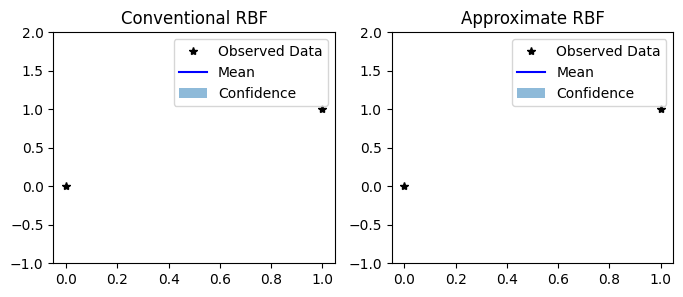

In [6]:
# set model to evaluation mode (predictive posterior)
conv_model.eval()
approx_model.eval()
conv_likelihood.eval()
approx_likelihood.eval()

# make predictions
with torch.no_grad():
    test_x = torch.linspace(0, 1, nb_test_points)
    conv_observed_pred = conv_likelihood(conv_model(test_x))
    approx_observed_pred = approx_likelihood(approx_model(test_x))

    conv_mean = conv_observed_pred.mean
    approx_mean = approx_observed_pred.mean

    conv_lower, conv_upper = conv_observed_pred.confidence_region()
    approx_lower, approx_upper = approx_observed_pred.confidence_region()

    # plot model fit
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

    # -- Conventional
    # plot training data as black stars
    ax1.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # plot predictive means as blue line
    ax1.plot(test_x.numpy(), conv_mean.numpy(), 'b')
    # shade between lower and upper confidence bounds
    ax1.fill_between(test_x.numpy(), conv_lower.numpy(), conv_upper.numpy(), alpha=0.5)
    ax1.set_ylim([-1, 2])

    ax1.legend(['Observed Data', 'Mean', 'Confidence'])
    ax1.set_title('Conventional RBF')

    # -- Approximate
    # plot training data as black stars
    ax2.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # plot predictive means as blue line
    ax2.plot(test_x.numpy(), approx_mean.numpy(), 'b')
    # shade between lower and upper confidence bounds
    ax2.fill_between(test_x.numpy(), approx_lower.numpy(), approx_upper.numpy(), alpha=0.5)
    ax2.set_ylim([-1, 2])

    ax2.legend(['Observed Data', 'Mean', 'Confidence'])
    ax2.set_title('Approximate RBF')

Getting predictive mean, variance and covariance matrix and sampling functions from GP:

In [7]:
with torch.no_grad():
    print("--Conventional--")
    conv_f_preds = conv_model(test_x)
    print("\tmean:\t\t", conv_f_preds.mean)
    print("\tcovar:\t\t", conv_f_preds.covariance_matrix.__repr__().replace(
        '\n        ',
        '\n' + 6*'\t' + ' '
    ))
    print("\tsamples:\t", conv_f_preds.sample(sample_shape=torch.Size((1,)))[0,])

    print("\n--Approximate--")
    approx_f_preds = approx_model(test_x)
    print("\tmean:\t\t", approx_f_preds.mean)
    print("\tcovar:\t\t", approx_f_preds.covariance_matrix.__repr__().replace(
        '\n        ',
        '\n' + 6*'\t' + ' '
    ))
    print("\tsamples:\t", approx_f_preds.sample(sample_shape=torch.Size((1,)))[0,])

--Conventional--
	mean:		 tensor([0.1029])
	covar:		 tensor([[0.3755]])
	samples:	 tensor([0.3093])

--Approximate--
eigenfunctions x1: tensor([[ 0.0000, -1.7119, -0.0000,  2.9650,  0.0000]])
eigenvalues: tensor([[0.2316, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0844, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0308, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0112, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0041]])
eigenfunction x2^T: tensor([[ 0.0000,  1.8455,  0.0000],
        [-1.7119,  4.7784, -1.7119],
        [-0.0000,  8.4198, -0.0000],
        [ 2.9650,  9.1706,  2.9650],
        [ 0.0000,  1.9351,  0.0000]])
eigenfunctions x1: tensor([[ 0.0000, -1.7119, -0.0000,  2.9650,  0.0000],
        [ 1.8455,  4.7784,  8.4198,  9.1706,  1.9351]])
eigenvalues: tensor([[0.2316, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0844, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0308, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0112, 0.00